<a href="https://colab.research.google.com/github/arfafax/StyleGAN2_experiments/blob/master/TFDNE_generate_interpolation_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Fursona Does Not Exist - Interpolation Videos

This notebook generates interpolation videos from the model used for http://thisfursonadoesnotexist.com/

To run it, click "Open in playground" above, and then Runtime > Run All.

In [ ]:
!git clone https://github.com/shawwn/stylegan2 -b estimator /content/stylegan2

Cloning into '/content/stylegan2'...
remote: Enumerating objects: 1104, done.
remote: Total 1104 (delta 0), reused 0 (delta 0), pack-reused 1104
Receiving objects: 100% (1104/1104), 849.84 KiB | 6.11 MiB/s, done.
Resolving deltas: 100% (782/782), done.


In [ ]:
import gdown
gdown.download('https://drive.google.com/uc?id=1t7E8NEqK_gVJwxrWEihR1IcPfekaBc1d', 'network-e621.pkl', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1t7E8NEqK_gVJwxrWEihR1IcPfekaBc1d
To: /content/network-e621.pkl
364MB [00:06, 56.0MB/s]


'network-e621.pkl'

In [ ]:
%tensorflow_version 1.x
%cd /content/stylegan2

TensorFlow 1.x selected.
/content/stylegan2


In [ ]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import scipy



attach_debugger <function attach_debugger at 0x7fefd83cc2f0>
print_status <function print_status at 0x7fefd83cc620>
freeze_forever <function freeze_forever at 0x7fefd83cc9d8>
quit <function quit at 0x7fefd83ccc80>
save_and_quit <function save_and_quit at 0x7fefd83cf048>
throw_exception <function throw_exception at 0x7fefd83cf2f0>


In [ ]:
tflib.init_tf()
_G, _D, Gs = pickle.load(open("/content/network-e621.pkl", "rb"))
# _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
# _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
# Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [ ]:
 def make_video(grid_size = [4, 4], duration_sec = 60.0, mp4_fps = 20, random_seed=397):
    #tflib.init_tf()

    #_G, _D, Gs = pickle.load(open("/content/network-e621.pkl", "rb"))
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

    image_shrink = 1
    image_zoom = 1
    smoothing_sec = 1.0
    mp4_codec = 'libx264'
    mp4_bitrate = '5M'
    mp4_file = 'random_grid_%s.mp4' % random_seed
    minibatch_size = 8

    num_frames = int(np.rint(duration_sec * mp4_fps))
    random_state = np.random.RandomState(random_seed)

    # Generate latent vectors
    shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
    all_latents = random_state.randn(*shape).astype(np.float32)
    import scipy
    all_latents = scipy.ndimage.gaussian_filter(all_latents,
                   [smoothing_sec * mp4_fps] + [0] * len(Gs.input_shape), mode='wrap')
    all_latents /= np.sqrt(np.mean(np.square(all_latents)))


    def create_image_grid(images, grid_size=None):
        assert images.ndim == 3 or images.ndim == 4
        num, img_h, img_w, channels = images.shape

        if grid_size is not None:
            grid_w, grid_h = tuple(grid_size)
        else:
            grid_w = max(int(np.ceil(np.sqrt(num))), 1)
            grid_h = max((num - 1) // grid_w + 1, 1)

        grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
        for idx in range(num):
            x = (idx % grid_w) * img_w
            y = (idx // grid_w) * img_h
            grid[y : y + img_h, x : x + img_w] = images[idx]
        return grid

    # Frame generation func for moviepy.
    def make_frame(t):
        frame_idx = int(np.clip(np.round(t * mp4_fps), 0, num_frames - 1))
        latents = all_latents[frame_idx]
        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
        images = Gs.run(latents, None, truncation_psi=0.75,
                              randomize_noise=False, output_transform=fmt)

        grid = create_image_grid(images, grid_size)
        if image_zoom > 1:
            grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
        if grid.shape[2] == 1:
            grid = grid.repeat(3, 2) # grayscale => RGB
        return grid

    # Generate video.
    import moviepy.editor
    video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
    video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)

    return mp4_file


In [ ]:
import math
from PIL import ImageFont
from PIL import ImageDraw
def interpolate_between_seeds(seed_array, truncation, duration_sec = 10.0, smoothing_sec = 1.0, mp4_fps = 20, filename=None, text=True):
    #_G, _D, Gs = pickle.load(open("/content/network-e621.pkl", "rb"))
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    if seed_array[0] != seed_array[-1]:
        seed_array.append(seed_array[0])
    
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    synthesis_kwargs = dict(output_transform=Gs_kwargs.output_transform, truncation_psi=truncation, minibatch_size=8)
    if truncation is not None:
        Gs_kwargs.truncation_psi = truncation
    rnd = np.random.RandomState(seed_array[0])
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
    batch_size = 1
    all_seeds = seed_array #[seed] * batch_size
    all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds]) # [minibatch, component]
    #print(all_z)
    #print(all_z.shape)
    all_w = []

    labels = []
    for i, seed in enumerate(seed_array):
        z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:])])
        #print(i, seed, z)
        all_w_src = Gs.components.mapping.run(z, None) # [minibatch, layer, component]
        if truncation != 1:
            w_avg = Gs.get_var('dlatent_avg')
            all_w_src = w_avg + (all_w_src - w_avg) * truncation # [minibatch, layer, component]
        all_w.append(all_w_src)
    #print(all_w)
    #print(len(all_w))
        
    num_frames = int(np.rint(duration_sec * mp4_fps))
        
    def make_frame(t):
        blend = ((len(seed_array)-1)*t/duration_sec)%1.0
        src_i = math.floor((t/duration_sec)*(len(seed_array)-1))
        dst_i = src_i + 1
        #print(t, blend, src_i, dst_i)
        all_w_new = (blend * all_w[dst_i]) + (1 - blend) * all_w[src_i]
        all_images_src = Gs.components.synthesis.run(all_w_new, randomize_noise=False, **synthesis_kwargs)
        #all_images_dst = Gs.components.synthesis.run(all_w_dst, randomize_noise=False, **synthesis_kwargs)
        if text:
            new_im = PIL.Image.new('RGB', (512, 600))
            new_im.paste(PIL.Image.fromarray(np.median(all_images_src, axis=0).astype(np.uint8)), (0, 0))
            draw = ImageDraw.Draw(new_im)
            font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", size=16)
            draw.text((10, 512), "{:0.2f}".format((1-blend)), (255, 0, 0), font=font)
            draw.text((50, 512), str(seed_array[src_i]), (255, 255, 255), font=font)
            draw.text((10, 550), "{:0.2f}".format((blend)), (0, 255, 0), font=font)
            draw.text((50, 550), str(seed_array[dst_i]), (255, 255, 255), font=font)
            return np.array(new_im)
        else:
            return all_images_src[0]

    
    import moviepy.editor
    mp4_file = 'interp_%s-%s.mp4' % (seed_array, truncation)
    if filename:
        mp4_file = filename
    mp4_codec = 'libx264'
    mp4_bitrate = '5M'

    video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
    video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)
    
    return mp4_file

In [ ]:
 from numpy import linalg
 import moviepy.editor
 def circular_interpolation(seed_a, seed_b, seed_c, radius = 40.0):
    rnd = np.random
    latents_a = np.random.RandomState(seed_a).randn(1, Gs.input_shape[1])
    latents_b = np.random.RandomState(seed_b).randn(1, Gs.input_shape[1])
    latents_c = np.random.RandomState(seed_c).randn(1, Gs.input_shape[1])

    def circ_generator(latents_interpolate):
        #radius = 40.0

        latents_axis_x = (latents_a - latents_b).flatten() / linalg.norm(latents_a - latents_b)
        latents_axis_y = (latents_a - latents_c).flatten() / linalg.norm(latents_a - latents_c)

        latents_x = math.sin(math.pi * 2.0 * latents_interpolate) * radius
        latents_y = math.cos(math.pi * 2.0 * latents_interpolate) * radius

        latents = latents_a + latents_x * latents_axis_x + latents_y * latents_axis_y
        return latents

    def mse(x, y):
        return (np.square(x - y)).mean()

    def generate_from_generator_adaptive(gen_func):
        max_step = 1.0
        current_pos = 0.0

        change_min = 10.0
        change_max = 11.0

        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)

        current_latent = gen_func(current_pos)
        current_image = Gs.run(current_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)[0]
        array_list = []

        video_length = 1.0
        while(current_pos < video_length):
            array_list.append(current_image)

            lower = current_pos
            upper = current_pos + max_step
            current_pos = (upper + lower) / 2.0

            current_latent = gen_func(current_pos)
            current_image = images = Gs.run(current_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)[0]
            current_mse = mse(array_list[-1], current_image)

            while current_mse < change_min or current_mse > change_max:
                if current_mse < change_min:
                    lower = current_pos
                    current_pos = (upper + lower) / 2.0

                if current_mse > change_max:
                    upper = current_pos
                    current_pos = (upper + lower) / 2.0


                current_latent = gen_func(current_pos)
                current_image = images = Gs.run(current_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)[0]
                current_mse = mse(array_list[-1], current_image)
            print(current_pos, current_mse)
        return array_list

    frames = generate_from_generator_adaptive(circ_generator)
    frames = moviepy.editor.ImageSequenceClip(frames, fps=30)

    # Generate video.
    print("Generating video")
    mp4_file = 'circular_%s-%s-%s-%s.mp4' % (seed_a, seed_b, seed_c, radius)
    #mp4_file = 'results/circular.mp4'
    mp4_codec = 'libx264'
    mp4_bitrate = '3M'
    mp4_fps = 20

    frames.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)
    return mp4_file

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)892928/45929032 bytes (1.9%)2555904/45929032 bytes (5.6%)5095424/45929032 bytes (11.1%)9011200/45929032 bytes (19.6%)12705792/45929032 bytes (27.7%)17006592/45929032 bytes (37.0%)21209088/45929032 bytes (46.2%)25436160/45929032 bytes (55.4%)29712384/45929032 bytes (64.7%)33964032/45929032 bytes (73.9%)38215680/45929032 bytes (83.2%)41918464/45929032 bytes (91.3%)45929

In [ ]:
 def generate_images(seeds, truncation_psi):
    #_G, _D, Gs = pickle.load(open("/content/network-e621.pkl", "rb"))
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if truncation_psi is not None:
        Gs_kwargs.truncation_psi = truncation_psi

    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        #print(z)
        tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        PIL.Image.fromarray(images[0], 'RGB').save('seed%04d.png' % seed)
        display(PIL.Image.fromarray(images[0], 'RGB'))

In [ ]:
 def blend_images(src_seed, dst_seed, blending=0.5, truncation_psi=0.7):
    #_G, _D, Gs = pickle.load(open("/content/network-e621.pkl", "rb"))
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    synthesis_kwargs = dict(output_transform=Gs_kwargs.output_transform, truncation_psi=truncation_psi, minibatch_size=8)
    if truncation_psi is not None:
        Gs_kwargs.truncation_psi = truncation_psi

    all_w = []

    for i, seed in enumerate([src_seed, dst_seed]):
        z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:])])
        #print(i, seed, z)
        all_w_src = Gs.components.mapping.run(z, None) # [minibatch, layer, component]
        if truncation_psi != 1:
            w_avg = Gs.get_var('dlatent_avg')
            all_w_src = w_avg + (all_w_src - w_avg) * truncation_psi # [minibatch, layer, component]
        all_w.append(all_w_src)
    
    w_new = (blending * all_w[0]) + (1 - blending) * all_w[1]
    images = Gs.components.synthesis.run(w_new, randomize_noise=False, **synthesis_kwargs)

    PIL.Image.fromarray(images[0], 'RGB').save('seed%04d.png' % seed)
    display(PIL.Image.fromarray(images[0], 'RGB'))

# Generate a single image

You can get the seed from the URL of an image on TFDNE.
For example: [https://thisfursonadoesnotexist.com/v2/jpgs-2x/seed85659.jpg](https://thisfursonadoesnotexist.com/v2/jpgs-2x/seed85659.jpg)

![seed 85659](https://thisfursonadoesnotexist.com/v2/jpgs/seed85659.jpg)

Generating image for seed 85659 (0/1) ...


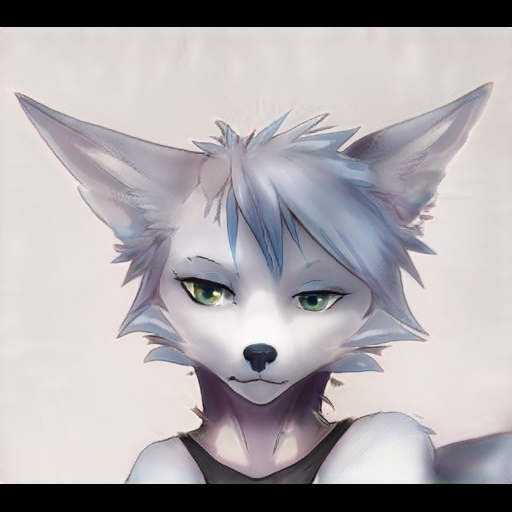

In [ ]:
#@title Generate an image { run: "auto", form-width: "30%"}
random_seed = 85659 #@param {type:"integer"}
truncation_psi = 0.75 #@param {type:"slider", min:0, max:1, step:0.05}
generate_images([random_seed], truncation_psi)

# Blend multiple seeds together to create a new image

Generating image for seed 85659 (0/2) ...


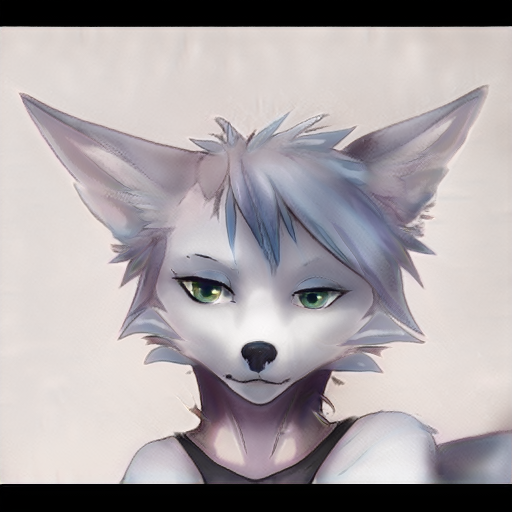

Generating image for seed 37989 (1/2) ...


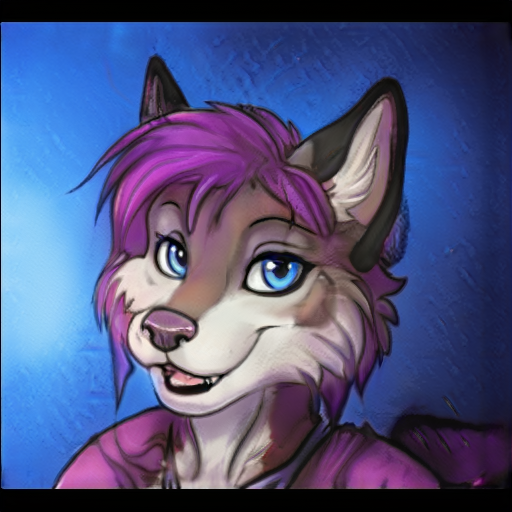

Blended image ( 0.5 )


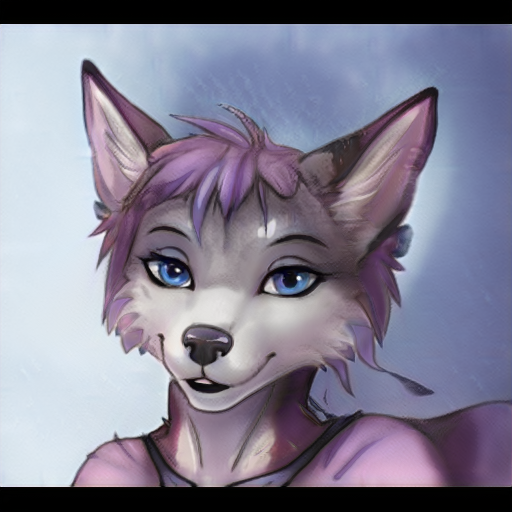

In [ ]:
#@title Blend two seeds { run: "auto", form-width: "30%"}
src_seed = 85659 #@param {type:"integer"}
dst_seed = 37989 #@param {type:"integer"}
blending = 0.5 #@param {type:"slider", min:0, max:1, step:0.05}
truncation_psi = 0.7 #@param {type:"slider", min:0, max:1, step:0.05}
generate_images([src_seed, dst_seed], truncation_psi)

print("Blended image (", blending, ")")
blend_images(src_seed, dst_seed, blending=blending, truncation_psi=truncation_psi)

# Interpolate between different seeds

Generating image for seed 85659 (0/2) ...


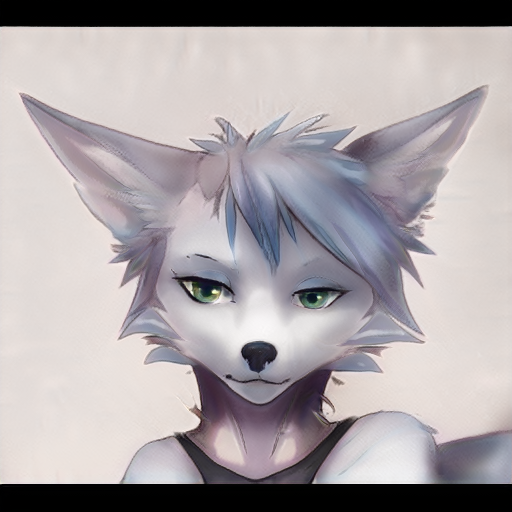

Generating image for seed 79605 (1/2) ...


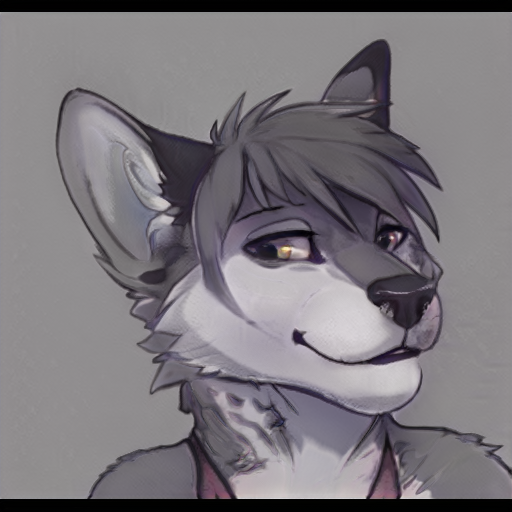

[MoviePy] >>>> Building video interp_[85659, 79605, 85659]-0.7.mp4
[MoviePy] Writing video interp_[85659, 79605, 85659]-0.7.mp4


100%|█████████▉| 200/201 [00:09<00:00, 20.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: interp_[85659, 79605, 85659]-0.7.mp4 



In [ ]:
#@title Generate an interpolation video { run: "auto", form-width: "30%"}
src_seed = 85659 #@param {type:"integer"}
dst_seed = 79605 #@param {type:"integer"}
truncation_psi = 0.7 #@param {type:"slider", min:0, max:1, step:0.05}
duration_sec = 10.0 #@param {type:"number"}
mp4_fps = 20 #@param {type:"integer"}
generate_images([src_seed, dst_seed], truncation_psi)
output_filename = interpolate_between_seeds(seed_array=[src_seed, dst_seed], truncation=truncation_psi, duration_sec=duration_sec, mp4_fps=mp4_fps)

In [ ]:
# You may need to run this cell twice to get the video to download
from google.colab import files
files.download(output_filename) 

# Generate a grid of interpolations

In [ ]:
#@title Generate an interpolation video { run: "auto", form-width: "30%" }
random_seed = 621 #@param {type:"integer"}
duration_sec = 10.0 #@param {type:"number"}
mp4_fps = 20 #@param {type:"integer"}
grid_width = 4 #@param {type:"integer"}
grid_height = 4 #@param {type:"integer"}
output_filename = make_video(grid_size=[grid_width,grid_height], duration_sec=duration_sec, mp4_fps=mp4_fps, random_seed=random_seed)

[MoviePy] >>>> Building video random_grid_621.mp4
[MoviePy] Writing video random_grid_621.mp4


100%|█████████▉| 200/201 [01:47<00:00,  1.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: random_grid_621.mp4 



In [ ]:
# You may need to run this cell twice to get the video to download
from google.colab import files
files.download(output_filename) 

# Generate circlular interpolation


In [ ]:
#@title Generate a circular interpolation video { run: "auto", form-width: "30%" }
seed_a = 30302 #@param {type:"integer"}
seed_b = 79605 #@param {type:"integer"}
seed_c = 37989 #@param {type:"integer"}
radius = 60.0 #@param {type:"number"}
output_filename = circular_interpolation(seed_a, seed_b, seed_c, radius)

0.00030517578125 10.711970011393229
0.0006103515625 10.856524149576822
0.00091552734375 10.848896026611328
0.001220703125 10.724870045979818
0.00152587890625 10.776673634847006
0.0018310546875 10.798999786376953
0.00213623046875 10.800788879394531
0.00244140625 10.801325480143229
0.00274658203125 10.547476450602213
0.0030517578125 10.242048899332682
0.00335693359375 10.30117925008138
0.003662109375 10.228925069173178
0.00396728515625 10.188002268473307
0.0042724609375 10.345211029052734
0.00457763671875 10.745705922444662
0.0048828125 10.74666976928711
0.00518798828125 10.77630360921224
0.0054931640625 10.892597198486328
0.00579833984375 10.994471232096354
0.006072998046875 10.222114562988281
0.006378173828125 10.91449228922526
0.006683349609375 10.862327575683594
0.006988525390625 10.860956827799479
0.007293701171875 10.721299489339193
0.007598876953125 10.847859700520834
0.007904052734375 10.88999048868815
0.008209228515625 10.648086547851562
0.008514404296875 10.579167683919271
0.00

100%|██████████| 1848/1848 [00:42<00:00, 43.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: circular_30302-79605-37989-60.0.mp4 



In [ ]:
# You may need to run this cell twice to get the video to download
from google.colab import files
files.download(output_filename) 